**INSTALL REQUIRED PACKAGES**

In [ ]:

!pip install -q shap xgboost gradio scikit-learn pandas numpy matplotlib seaborn plotly


**DATASET EXTRACTION & LOADING**

In [ ]:

import zipfile
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Extract dataset
zip_path = "/content/archive (6).zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Dataset extracted successfully!")

# Load data
data = pd.read_csv("/content/dataset/student-mat.csv", sep=';')
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
data.head()


✅ Dataset extracted successfully!
Dataset shape: (395, 33)

First 5 rows:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


 **EXPLORATORY DATA ANALYSIS (EDA)**

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 

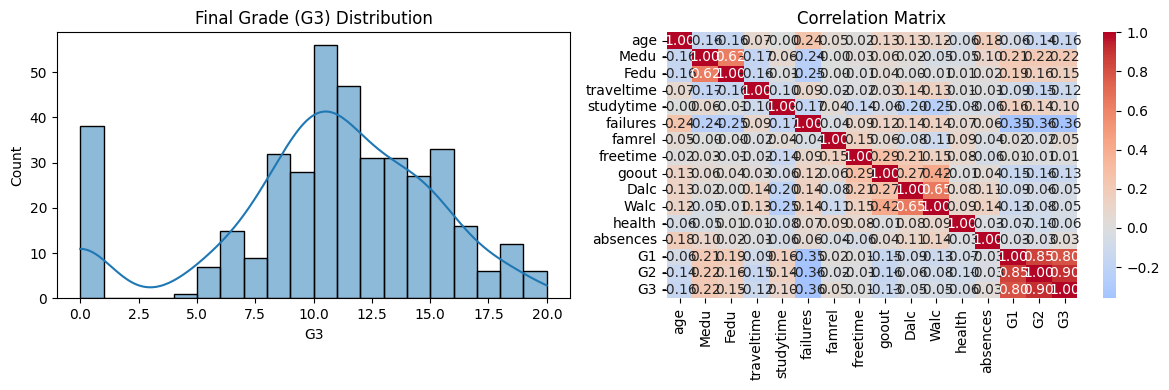


Top correlations with G3:
G3           1.000000
G2           0.904868
G1           0.801468
Medu         0.217147
Fedu         0.152457
studytime    0.097820
famrel       0.051363
absences     0.034247
freetime     0.011307
Walc        -0.051939
Name: G3, dtype: float64


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Basic info
print("Dataset Info:")
print(data.info())
print("\nMissing values:")
print(data.isnull().sum())

# Target distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data['G3'], bins=20, kde=True)
plt.title('Final Grade (G3) Distribution')

# Correlation heatmap (numeric features)
plt.subplot(1, 2, 2)
numeric_cols = data.select_dtypes(include=[np.number]).columns
corr_matrix = data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# High correlation with G3
g3_corr = data[numeric_cols].corr()['G3'].sort_values(ascending=False)
print("\nTop correlations with G3:")
print(g3_corr.head(10))


**ADVANCED FEATURE ENGINEERING (FIXED)**

In [ ]:

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert binary categorical columns to numeric FIRST (yes/no -> 1/0)
binary_cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for col in binary_cols:
    data[col] = data[col].map({'yes': 1, 'no': 0}).fillna(0).astype(int)

print("✅ Binary columns converted to numeric!")

# NOW create new features safely
data['G_avg'] = (data['G1'] + data['G2']) / 2  # Average of previous grades
data['grade_improvement'] = data['G2'] - data['G1']  # Grade trend
data['study_effort'] = data['studytime'] * data['health']  # Interaction term
data['risk_score'] = data['failures'] * data['absences'] / 100  # Risk indicator
data['total_support'] = data['schoolsup'] + data['famsup'] + data['paid']  # Now safe!

# Handle outliers in grades (clip extreme values)
data['G1'] = np.clip(data['G1'], 0, 20)
data['G2'] = np.clip(data['G2'], 0, 20)
data['G3'] = np.clip(data['G3'], 0, 20)

# Encode remaining categorical variables (non-binary)
le = LabelEncoder()
categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                   'reason', 'guardian']
for col in categorical_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col])

print("✅ Feature engineering completed!")
print(f"New dataset shape: {data.shape}")
print("\nSample of processed data:")
print(data[['G1', 'G2', 'G3', 'total_support', 'study_effort', 'risk_score']].head())


✅ Binary columns converted to numeric!
✅ Feature engineering completed!
New dataset shape: (395, 38)

Sample of processed data:
   G1  G2  G3  total_support  study_effort  risk_score
0   5   6   6              1             6         0.0
1   5   5   6              1             6         0.0
2   7   8  10              2             6         0.3
3  15  14  15              2            15         0.0
4   6  10  10              2            10         0.0


**DATA PREPROCESSING & SPLITTING**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Prepare features and target
X = data.drop('G3', axis=1)
y = data['G3']

print(f"Features before selection: {X.shape[1]}")
print("Top 10 feature importances (univariate):")
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print(selected_features[:10])

# Use selected features
X = X[selected_features]
y = y

# Train-test split (stratified by grade ranges)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)

# Robust scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Training set: {X_train_scaled.shape}")
print(f"✅ Test set: {X_test_scaled.shape}")


Features before selection: 37
Top 10 feature importances (univariate):
['sex', 'age', 'address', 'Medu', 'Fedu', 'Mjob', 'reason', 'traveltime', 'studytime', 'failures']
✅ Training set: (316, 20)
✅ Test set: (79, 20)


**MULTIPLE MODEL TRAINING WITH HYPERPARAMETER TUNING**

In [ ]:

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. XGBoost with tuning
xgb_params = {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
xgb_model = XGBRegressor(**xgb_params, random_state=42)

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# 3. Improved ANN
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train ANN
ann_history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=200, batch_size=32, validation_split=0.2,
    callbacks=[early_stop, lr_reducer], verbose=0
)

# Ensemble model
ensemble = VotingRegressor([
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('ridge', Ridge(alpha=1.0))
])

print("✅ All models trained!")


✅ All models trained!


**MODEL EVALUATION & COMPARISON**

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
models = {
    'XGBoost': xgb_model.fit(X_train, y_train).predict(X_test),
    'RandomForest': rf_model.fit(X_train, y_train).predict(X_test),
    'ANN': ann_model.predict(X_test_scaled).flatten(),
    'Ensemble': ensemble.fit(X_train, y_train).predict(X_test)
}

# Evaluation metrics
results = {}
for name, y_pred in models.items():
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df.round(4))

# Cross-validation scores
cv_scores = {}
for name, model in [('XGBoost', xgb_model), ('RandomForest', rf_model)]:
    cv_scores[name] = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
print("\nCross-validation R² scores:")
for name, score in cv_scores.items():
    print(f"{name}: {score:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Model Performance Comparison:
                 MAE    RMSE      R2
XGBoost       1.3430  2.2462  0.7511
RandomForest  1.1681  1.9996  0.8027
ANN           1.5760  2.4143  0.7124
Ensemble      1.1430  2.0310  0.7965

Cross-validation R² scores:
XGBoost: 0.8272
RandomForest: 0.8221


**SHAP FEATURE IMPORTANCE**

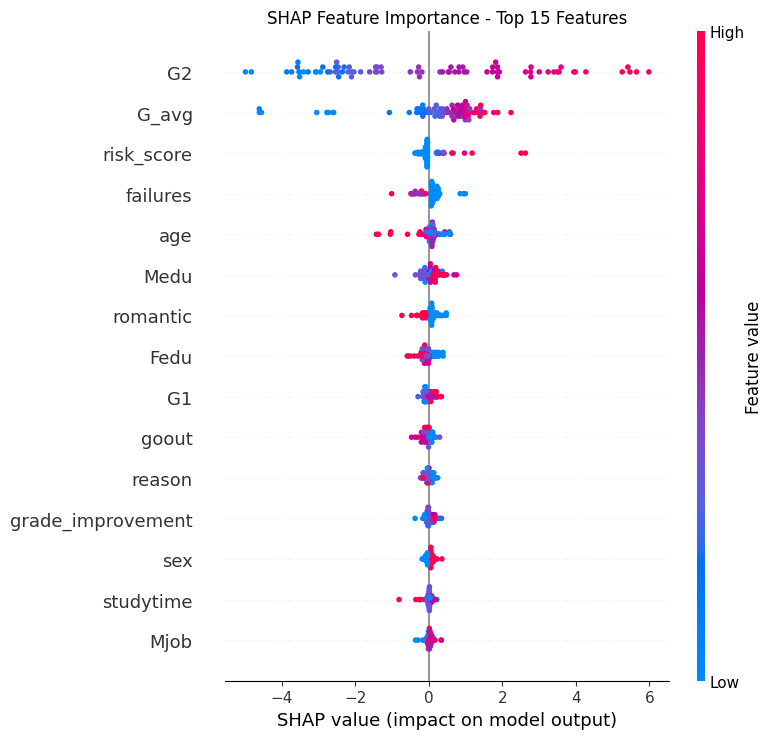

✅ SHAP analysis completed! Top features impact predictions most.


In [ ]:

import shap

# SHAP for XGBoost (fastest)
explainer = shap.TreeExplainer(xgb_model.fit(X_train, y_train))
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, max_display=15, show=False)
plt.title('SHAP Feature Importance - Top 15 Features')
plt.tight_layout()
plt.show()

print("✅ SHAP analysis completed! Top features impact predictions most.")


**GRADIO: FEATURE GROUPING FOR TABS**

In [ ]:


# Use the selected features from your preprocessing step
feature_names = list(X.columns)

# Example grouping (edit labels / features if you like)
student_info_feats = ['age', 'absences', 'studytime', 'failures']
lifestyle_feats = ['goout', 'Dalc', 'Walc', 'health', 'freetime']
academic_feats = ['G1', 'G2', 'G_avg', 'grade_improvement']

# Keep only features that actually exist in X
student_info_feats = [f for f in student_info_feats if f in feature_names]
lifestyle_feats = [f for f in lifestyle_feats if f in feature_names]
academic_feats = [f for f in academic_feats if f in feature_names]

# Any remaining features (if you want them later)
other_feats = [f for f in feature_names
               if f not in student_info_feats + lifestyle_feats + academic_feats]
print("Student tab:", student_info_feats)
print("Lifestyle tab:", lifestyle_feats)
print("Academic tab:", academic_feats)
print("Other features (not exposed in UI):", other_feats)


Student tab: ['age', 'studytime', 'failures']
Lifestyle tab: ['goout']
Academic tab: ['G1', 'G2', 'G_avg', 'grade_improvement']
Other features (not exposed in UI): ['sex', 'address', 'Medu', 'Fedu', 'Mjob', 'reason', 'traveltime', 'paid', 'higher', 'internet', 'romantic', 'risk_score']


**PREDICTION FUNCTION**

In [ ]:

import pandas as pd
import numpy as np

def predict_performance(
    # Student Information
    age, absences, studytime, failures,
    # Lifestyle Factors
    goout, dalc, walc, health, freetime,
    # Academic Performance
    g1, g2
):
    # Build a dict with all model features, default 0
    input_dict = {f: 0.0 for f in feature_names}

    # Map UI inputs to real feature names
    ui_map = {
        'age': age,
        'absences': absences,
        'studytime': studytime,
        'failures': failures,
        'goout': goout,
        'Dalc': dalc,
        'Walc': walc,
        'health': health,
        'freetime': freetime,
        'G1': g1,
        'G2': g2,
    }

    for k, v in ui_map.items():
        if k in input_dict:
            input_dict[k] = float(v)

    # Recreate engineered features if they exist in X
    if 'G_avg' in input_dict:
        input_dict['G_avg'] = (input_dict.get('G1', 0) + input_dict.get('G2', 0)) / 2
    if 'grade_improvement' in input_dict:
        input_dict['grade_improvement'] = input_dict.get('G2', 0) - input_dict.get('G1', 0)
    if 'study_effort' in input_dict:
        input_dict['study_effort'] = input_dict.get('studytime', 0) * input_dict.get('health', 0)

    # Create dataframe in correct column order
    input_df = pd.DataFrame([input_dict], columns=feature_names)

    # Scale where needed
    input_scaled = scaler.transform(input_df)

    # Individual model predictions
    xgb_pred = xgb_model.predict(input_df)[0]
    rf_pred = rf_model.predict(input_df)[0]
    ann_pred = ann_model.predict(input_scaled)[0][0]
    ensemble_pred = ensemble.predict(input_df)[0]

    # Weighted final prediction
    final_pred = (
        0.4 * ensemble_pred +
        0.3 * xgb_pred +
        0.2 * rf_pred +
        0.1 * ann_pred
    )

    # Pass/fail & risk
    status = "PASS ✅" if final_pred >= 10 else "FAIL ❌"
    if final_pred < 8:
        risk = "HIGH RISK"
    elif final_pred < 12:
        risk = "MEDIUM RISK"
    else:
        risk = "LOW RISK"

    return f"""
🎯 **Prediction Result**

📊 **Predicted Final Grade (G3):** {final_pred:.1f} / 20
✅ **Status:** {status}
⚠️ **Risk Level:** {risk}

🤖 **Model Predictions**
• XGBoost: {xgb_pred:.2f}
• Random Forest: {rf_pred:.2f}
• ANN: {ann_pred:.2f}
• Ensemble: {ensemble_pred:.2f}
"""


**. GRADIO INTERFACE WITH TABS + MODEL COMPARISON**


In [ ]:

import gradio as gr

with gr.Blocks(title="ANN-based Student Performance Prediction") as demo:
    gr.Markdown("## ANN-based Student Performance Prediction")

    with gr.Tabs():
        # ---------- Tab 1: Student Information ----------
        with gr.TabItem("👨‍🎓 Student Information"):
            age = gr.Slider(15, 22, value=15, step=1, label="Age")
            absences = gr.Slider(0, 100, value=0, step=1, label="Absences")
            studytime = gr.Slider(1, 4, value=1, step=1, label="Study Time (1–4)")
            failures = gr.Slider(0, 4, value=0, step=1, label="Past Failures")

        # ---------- Tab 2: Lifestyle Factors ----------
        with gr.TabItem("🏡 Lifestyle Factors"):
            goout = gr.Slider(1, 5, value=3, step=1, label="Going Out (1–5)")
            dalc = gr.Slider(1, 5, value=1, step=1, label="Workday Alcohol (Dalc)")
            walc = gr.Slider(1, 5, value=1, step=1, label="Weekend Alcohol (Walc)")
            health = gr.Slider(1, 5, value=3, step=1, label="Health Status (1–5)")
            freetime = gr.Slider(1, 5, value=3, step=1, label="Free Time (1–5)")

        # ---------- Tab 3: Academic Performance ----------
        with gr.TabItem("📚 Academic Performance"):
            g1 = gr.Slider(0, 20, value=10, step=1, label="G1 (First Period Grade)")
            g2 = gr.Slider(0, 20, value=10, step=1, label="G2 (Second Period Grade)")

        # ---------- Predict Button & Output ----------
        predict_btn = gr.Button("🚀 Predict Result")
        result_box = gr.Markdown()

        predict_btn.click(
            fn=predict_performance,
            inputs=[age, absences, studytime, failures,
                    goout, dalc, walc, health, freetime,
                    g1, g2],
            outputs=result_box
        )

        # ---------- Extra Tab: Model Comparison (kept) ----------
        with gr.TabItem("📊 Model Comparison"):
            gr.Markdown("### Model Performance (Test Set)")
            gr.Dataframe(
                value=results_df.round(4),
                interactive=False,
                label="MAE / RMSE / R² for each model"
            )

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c078a3a5d2cbb82fb2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
